# <center> Exponentially Weighted Moving Average algorithm </center>

## Mathematical background

The Exponentially Weighted Moving Average or EWMA algorithm (<a href="https://www.tandfonline.com/doi/abs/10.1080/00401706.1959.10489860">Roberts 1959</a>) introduces a statistic $Z_j$ defined as $Z_0 = \mu$ and

$$
Z_j = (1 - r) Z_{j-1} + r x_j,
$$

for $j \in \{ 1, 2, ... \}$ where $r$ is a control parameter which is used as a learning rate. One can then derive the variance of $Z_j$ as

$$
\mathbb{V}[Z_j] = \mathbb{E}[Z_j^2] - \mathbb{E}[Z_j]^2.
$$

On the one hand, using properties on arithmetico–geometric sequences

$$
\begin{aligned}
\mathbb{E}[Z_j] &= (1 - r) \mathbb{E}[Z_{j-1}] + r \mathbb{E}[x_j] \\
&= (1 - r)^j \underbrace{\left( \mathbb{E}[Z_0] - \frac{r \mu}{1 - (1-r)} \right)}_{=\mu - \mu = 0} + \frac{r \mu}{1 - (1-r)} \\
\mathbb{E}[Z_j] &= \mu.
\end{aligned}
$$

On the other hand, in a similar way

$$
\begin{aligned}
\mathbb{E}[Z_j^2] &= (1-r)^2 \mathbb{E}[Z_{j-1}^2] + r^2 \underbrace{\mathbb{E}[x_j^2]}_{=\sigma^2 + \mu^2} + 2r(1-r) \underbrace{\mathbb{E}[Z_{j-1}]}_{=\mu} \underbrace{\mathbb{E}[x_j]}_{=\mu} \\
&= (1-r)^2 \mathbb{E}[Z_{j-1}^2] + r^2 \sigma^2 - r^2 \mu^2 + 2r \mu^2 \\
&= (1-r)^{2j} \left( \mathbb{E}[Z_0^2] - \frac{r^2 \sigma^2 - r^2 \mu^2 + 2r \mu^2}{2 - r} \right) + \frac{r^2 \sigma^2 - r^2 \mu^2 + 2r \mu^2}{2 - r} \\
\mathbb{E}[Z_j^2] &= \frac{r^2 \sigma^2 - r^2 \mu^2 + 2r \mu^2}{2 - r} - \sigma^2 (1-r)^{2j} \frac{r}{2-r}.
\end{aligned}
$$

Therefore,

$$
\begin{aligned}
\mathbb{V}[Z_j] &= \frac{r^2 \sigma^2 - r^2 \mu^2 + 2r \mu^2}{2 - r} - \sigma^2 (1-r)^{2j} \frac{r}{2-r} - \mu^2 \\
\mathbb{V}[Z_j] &= \sigma^2 \frac{r}{2-r} \left( 1 - (1 - r)^{2j} \right).
\end{aligned}
$$

Hence,

$$
\sigma_{Z_j} = \sigma \sqrt{\frac{r}{2-r} \left[ 1 - (1 - r)^{2j} \right]}.
$$

Note that both $\mu$ and $\sigma$ can be updated sequentially and efficiently, without having to store all previous observations $x_j$, using 
$$
\begin{aligned}
\mu_n &= \frac{n-1}{n} \mu_{n-1} + \frac{1}{n} x_n, \\
\sigma_n^2 &= \frac{n-2}{n-1} \sigma_{n-1}^2 + \frac{(x_n - \mu_n) (x_{n-1} - \mu_{n-1})}{n-1}.
\end{aligned}
$$

A change is then detected when either $Z_j > \mu + L \sigma_{Z_j}$ or $Z_j < \mu - L \sigma_{Z_j}$ where $L$ is another control parameter which needs to be chosen and represents the sensitivity of the algorithm. 

Some papers suggest values in the range $r \in [0.05, 1]$ and $L \in [2.4, 3.0]$ based on desired $ARL_0$. However, values for $r$ and $L$ may sometimes be specific to a particular problem or application.

## EWMA in `ocpdet`

Install `ocpdet` package by running the command line: `pip install ocdpet` and import EWMA as

In [1]:
from ocpdet import EWMA

First, let's generate some artificial data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

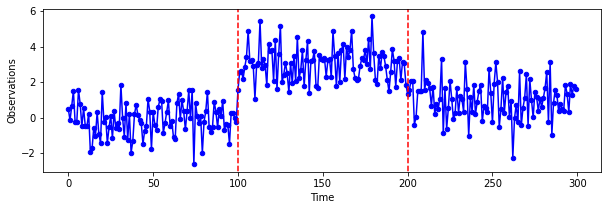

In [3]:
np.random.seed(42)

data = np.concatenate([
    np.random.normal(loc=0., scale=1., size=(100,)),
    np.random.normal(loc=3., scale=1., size=(100,)),
    np.random.normal(loc=1., scale=1., size=(100,)),
])

plt.figure(figsize=(10, 3))
plt.scatter(range(0, len(data)), data, c="b", s=20)
plt.plot(range(0, len(data)), data, c="b")
plt.xlabel("Time")
plt.ylabel("Observations")
plt.axvline(100, min(data), max(data), color="r", linestyle="--")
plt.axvline(200, min(data), max(data), color="r", linestyle="--")
plt.show()

EWMA is implemented as a `Class` in `ocpdet` and it can be initialised such as

In [4]:
model = EWMA(r=0.15, L=2.4, burnin=50, mu=0., sigma=1.)

We can now process this data stream using the EWMA object `model` that we created.

In [5]:
model.process(data)

We can now retrieve detected changepoints using the `changepoints` attribute of the `model` object.

In [6]:
model.changepoints

[102, 204]

This isn't too bad as true changepoints occurred at times $t=100$ and $t=200$. The `EWMA` object also brings flexibility and access to the algorithm statistics $Z$ and $\sigma_Z$ defined previously, using the `Z` and `sigma_Z` attributes of the object.

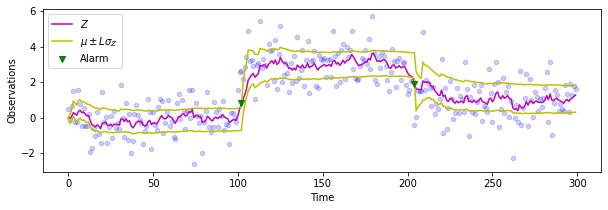

In [7]:
plt.figure(figsize=(10, 3))
plt.scatter(range(0, len(data)), data, c="b", s=20, alpha=0.2)
plt.plot(range(0, len(data)), model.Z, c="m", label="$Z$")
plt.plot(range(0, len(data)), np.asarray(model._mu) + np.asarray(model.sigma_Z) * model.L,
         c="y", label="$\mu \pm L \sigma_Z$")
plt.plot(range(0, len(data)), np.asarray(model._mu) - np.asarray(model.sigma_Z) * model.L,
         c="y")
plt.scatter(model.changepoints, np.asarray(model.Z)[model.changepoints], marker="v",
            label="Alarm", color="green", zorder=10)
plt.xlabel("Time")
plt.ylabel("Observations")
plt.legend()
plt.show()